In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
from IPython.display import clear_output

import sys
sys.path.append("..") 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils

In [ ]:
# Fetch the dataset

RUNNING_ON_COLAB = True

train_data_path = '.'
val_data_path   = '.'
test_data_path  = '.'

# Paths if runninc on colab
if RUNNING_ON_COLAB:
    from google.colab import drive
    drive.flush_and_unmount()
    drive.mount('/gdrive', force_remount=False)

    def_colab_path = '/gdrive/My Drive/Colab Notebooks/CaloGAN/'
    sys.path.append(def_colab_path)

    train_data_path = def_colab_path + 'data/data_train.npz'
    val_data_path   = def_colab_path + 'data/data_val.npz'
    test_data_path  = def_colab_path + 'data/data_test.npz'
else:
    # Paths if running locally
    train_data_path = './data/data_train.npz'
    val_data_path   = './data/data_val.npz'
    test_data_path  = './data/data_test.npz'

# Load data
data_train = np.load(train_data_path, allow_pickle=False)

# Preprocess
# ...

Mounted at /gdrive


In [ ]:
# Import source code

from analysis.calogan_metrics import *
from analysis.prd_score       import *
from analysis.score           import *

from src.data_manipulation  import *
from src.gan_losses         import *
from src.plotting_functions import *
from src.training_procedure import *

In [ ]:
# Set up the device

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Available device =", device)

Available device = cuda


In [ ]:
def train_model(epoch_num, particle_type_id, discriminator, generator,
                train_size = 16000, valid_size = -1, valid_ratio = 0.05, 
                batch_size = 1024, dis_iter_num = 3, gen_iter_num = 1, 
                noise_dim = 30, 
                if_normalise_energies=False, if_rotate_dataset=False, if_logarithm_energies=False,
                loss = 'HINGE'):
    MAX_TRAIN_SIZE = data_train['ParticlePDG'].shape[0]
    
    if valid_size < 0:
        valid_size = int(valid_ratio * train_size)

    if_one_particle_transf = True
    
    if particle_type_id < 0:
        if_one_particle_transf = False

    train_dataset, valid_dataset, _, _ = get_datasets(data_train, train_size, valid_size,
                                                      one_particle_transf=if_one_particle_transf, 
                                                      particle_id=particle_type_id,
                                                      rotate_transf=if_rotate_dataset, 
                                                      normalise_energies=if_normalise_energies,
                                                      logarithm_energies=if_logarithm_energies)

    train_dataloader = utils.DataLoader(train_dataset, batch_size=batch_size, 
                                        pin_memory=True, shuffle=True)
    valid_dataloader = utils.DataLoader(valid_dataset, batch_size=batch_size, 
                                        pin_memory=True, shuffle=False)

    res_train_size, res_valid_size = len(train_dataset), len(valid_dataset)

    print()
    print('Particle ID', particle_type_id)
    print('Max train dataset size', MAX_TRAIN_SIZE)
    print('Training dataset size =', res_train_size)
    print('Validation dataset size =', res_valid_size)
    print(list(data_train.keys()))
    print()

    #energy_b, mom_b, point_b, pdg_b = valid_dataloader.dataset[8]
    #energy_b = energy_b.reshape((1,1,30,30))
    #plot_energy_and_shower(energy_b, energy_b)

    training = TrainingProcedure(loss, discriminator, generator,
                                 train_dataloader, valid_dataloader,
                                 batch_size, res_valid_size, device,
                                 dis_iter_num=dis_iter_num, gen_iter_num=gen_iter_num, 
                                 noise_dim = noise_dim, loss=loss, INSTANCE_NOISE=INSTANCE_NOISE)
    training.run(epoch_num, True)
    return training, training.best_models

def save_generator(generator, filename, noise_dim=30):
    generator_cpu = FccGanGenerator(z_dim=noise_dim)
    generator_cpu.load_state_dict(generator.state_dict())
    generator_cpu.eval()

    # Save the trained model on google disk
    torch.save(generator_cpu.state_dict(), def_colab_path + filename)
    print('The model is saved to', def_colab_path + filename)
    return

In [ ]:
def check_models(discriminator, generator):
    # size of the train dataset
    # (change to a lower value if you require a subset)
    # (dataset transformations like rotations will change the specified value!)
    MAX_TRAIN_SIZE = data_train['ParticlePDG'].shape[0]
    TRAIN_SIZE = 5000
    VALID_RAT  = 0.1
    VALID_SIZE = int(VALID_RAT * TRAIN_SIZE)

    train_dataset, valid_dataset, _, _ = get_datasets(data_train, TRAIN_SIZE, VALID_SIZE, 
                                                      one_particle_transf=True, particle_id=11.)

    BATCH_SIZE = 512

    train_dataloader = utils.DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                                        pin_memory=True, shuffle=True)
    valid_dataloader = utils.DataLoader(valid_dataset, batch_size=BATCH_SIZE, 
                                        pin_memory=True, shuffle=False)

    #print('Max train dataset size', MAX_TRAIN_SIZE)
    #print("Training dataset size =", TRAIN_SIZE)
    #print("Validation dataset size =", VALID_SIZE)
    #print(list(data_train.keys()))

    discriminator = discriminator.to(device)
    generator = generator.to(device)

    for EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b, PDG_b in train_dataloader:
        break

    EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b = EnergyDeposit_b.to(device), \
                                                        ParticleMomentum_b.to(device), \
                                                        ParticlePoint_b.to(device)
    ParticleMomentum_ParticlePoint_b = torch.cat([ParticleMomentum_b.to(device), ParticlePoint_b.to(device)], dim=1)

    print(EnergyDeposit_b.shape)
    print(ParticleMomentum_ParticlePoint_b.shape)
    print(discriminator(EnergyDeposit_b, ParticleMomentum_ParticlePoint_b).shape)
    noise = torch.randn(len(EnergyDeposit_b), NOISE_DIM).to(device)
    print('Generator output shape:', generator(noise, ParticleMomentum_ParticlePoint_b).shape)
    print(noise[0])
    print(ParticleMomentum_ParticlePoint_b[0])
    print(torch.cat([noise, ParticleMomentum_ParticlePoint_b], dim=1)[0])

    del train_dataloader, valid_dataloader;
    del EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b;
    del discriminator, generator;
    del train_dataset, valid_dataset;

In [ ]:
from torch.nn.utils import spectral_norm

class Generator(nn.Module):
    def __init__(self, z_dim, act_func = F.relu):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.activation = act_func

        # 128 + 5 -> (+reshape) 128 x 2 x 2
        self.fc1 = nn.Linear(self.z_dim + 5, self.z_dim * 2 * 2)

        # Z x 2 x 2
        self.conv1 = nn.ConvTranspose2d(self.z_dim, 128, 3, stride=2, padding=1, output_padding=1) 
        # 128 x 8 x 8
        self.conv2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        # 64 x 16 x 16
        self.conv3 = nn.ConvTranspose2d(64, 32,  3, stride=2, padding=1, output_padding=1)
        # 32 x 32 x 32
        self.conv4 = nn.ConvTranspose2d(32, 1,  3, stride=2, padding=1, output_padding=1)
        # 1 x 32 x 32
        # crop
        # 1 x 30 x 30

        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(32)

                
    def forward(self, z, ParticleMomentum_ParticlePoint):
        x = torch.cat([z, ParticleMomentum_ParticlePoint], dim=1)
        #print(x.shape)
        x = F.leaky_relu(self.fc1(x))

        #print(x.shape)
        EnergyDeposit = x.view(-1, self.z_dim, 2, 2)

        #print(EnergyDeposit.shape)
        EnergyDeposit = self.activation(self.bn1(self.conv1(EnergyDeposit)))
        #print(EnergyDeposit.shape)
        EnergyDeposit = self.activation(self.bn2(self.conv2(EnergyDeposit)))
        #print(EnergyDeposit.shape)
        EnergyDeposit = self.activation(self.bn3(self.conv3(EnergyDeposit)))
        #print(EnergyDeposit.shape)
        EnergyDeposit = self.activation(self.conv4(EnergyDeposit))
        #print(EnergyDeposit.shape)
        EnergyDeposit = EnergyDeposit[:,:,1:31,1:31]
        #print(EnergyDeposit.shape)
                
        return EnergyDeposit

class Discriminator(nn.Module):
    def __init__(self, act_func = F.leaky_relu):
        super(Discriminator, self).__init__()
        self.activation = act_func

        # 30x30x1 -> 32x32x1 (padding)
        # 32x32x1
        self.conv1 = nn.Conv2d( 1,   32, 3, stride=2, padding=1)
        # 16x16x32
        self.conv2 = nn.Conv2d( 32,  64, 3, stride=2, padding=0)
        # 8x8x64
        self.conv3 = nn.Conv2d( 64, 128, 3, stride=2, padding=0)
        # 2x2x256
        self.conv4 = nn.Conv2d(128, 256, 3, stride=2, padding=0)
        # 1x1x256
        self.conv5 = nn.Conv2d(256, 256, 3, stride=2, padding=0)

        # 5x5x256 = 6400
        self.fc1 = nn.Linear(256 + 5, 64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,1)
        
    def forward(self, EnergyDeposit, ParticleMomentum_ParticlePoint):
        #print(EnergyDeposit.shape)
        X = self.activation(self.conv1(EnergyDeposit))
        #print(X.shape)
        X = self.activation(self.conv2(X))
        #print(X.shape)
        X = self.activation(self.conv3(X))
        #print(X.shape)
        X = self.activation(self.conv4(X))
        #print(X.shape)

        X = X.reshape(-1,256)
        #print(X.shape)
        X = torch.cat([X, ParticleMomentum_ParticlePoint], dim=1)
        #print(X.shape)
        
        X = F.leaky_relu(self.fc1(X))
        #print(X.shape)
        X = F.leaky_relu(self.fc2(X))
        #print(X.shape)

        if TASK in ['WASSERSTEIN', 'HINGE']:
            return self.fc3(X)
        else:
            return torch.sigmoid(self.fc3(X))

https://stackoverflow.com/questions/684171/how-to-re-import-an-updated-package-while-in-python-interpreter

Epoch #19
Mean discriminator output on real data = 1890.84
Mean discriminator output on generated data = 1134.11


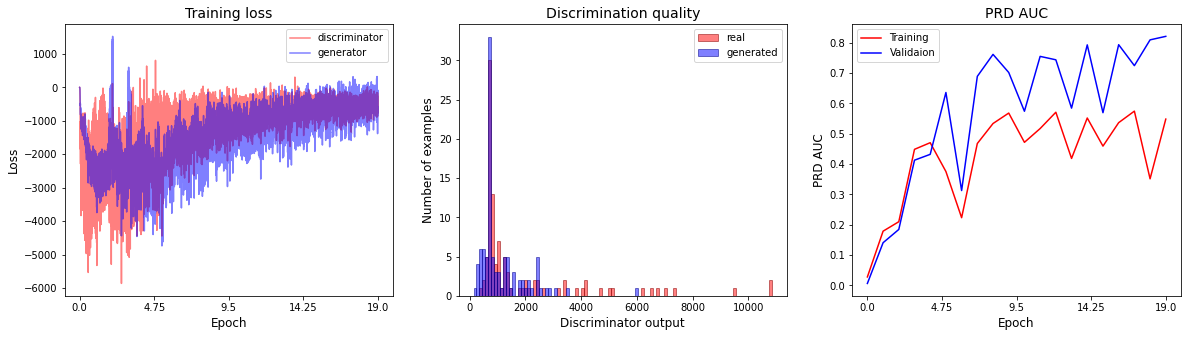

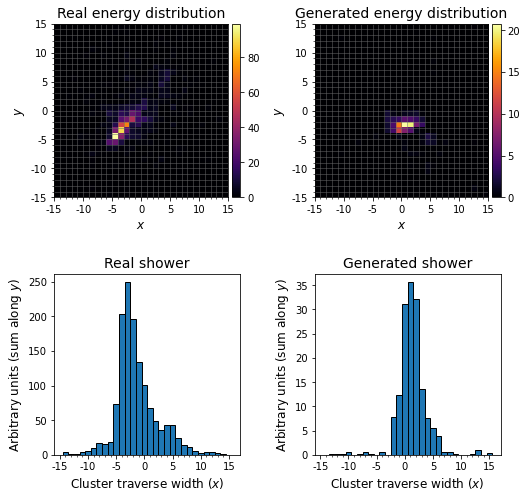

100%|██████████| 20/20 [1:13:57<00:00, 221.86s/it]


In [ ]:
import pickle

NOISE_DIM = 256
N_EPOCHS  = 20
filename = 'august-4.pt'

# Max train  dataset size = 50250
# Training   dataset size = 47166
# Validation dataset size = 3072

tr_class, pos_gen_models = train_model(N_EPOCHS, -123., train_size = 47166, valid_size = 3084,
                                       batch_size=256,
                                       discriminator = Discriminator(), 
                                       generator = Generator(NOISE_DIM),
                                       dis_iter_num=1, gen_iter_num=1,
                                       loss='WASSERSTEIN',
                                       if_logarithm_energies=False,
                                       noise_dim = NOISE_DIM)

Epoch #19
Mean discriminator output on real data = 3108.76
Mean discriminator output on generated data = 2011.24


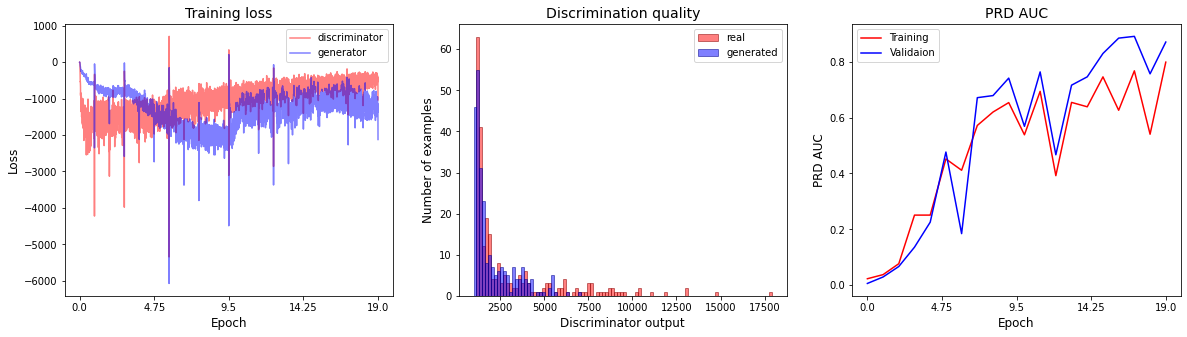

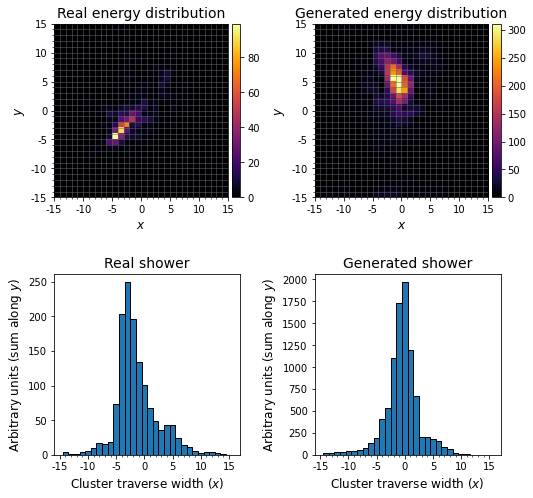

100%|██████████| 20/20 [1:35:22<00:00, 286.14s/it]


In [ ]:
import pickle

NOISE_DIM = 256
N_EPOCHS  = 20
filename = 'august-4.pt'

# Max train  dataset size = 50250
# Training   dataset size = 47166
# Validation dataset size = 3072

tr_class, pos_gen_models = train_model(N_EPOCHS, -123., train_size = 47166, valid_size = 3084,
                                       batch_size=256,
                                       discriminator = Discriminator(), 
                                       generator = Generator(NOISE_DIM),
                                       dis_iter_num=2, gen_iter_num=1,
                                       loss='WASSERSTEIN',
                                       if_logarithm_energies=False,
                                       noise_dim = NOISE_DIM)

In [ ]:
with open(def_colab_path + filename, 'wb') as pickle_file:
    pickle.dump(tr_class, pickle_file)

In [17]:
# Load training class and save the model

import pickle

new_tr_class = None
filename = 'august-4.pt'

# load training class
with open(def_colab_path + filename, 'rb') as pickle_file:
    new_tr_class = pickle.load(pickle_file)
    
model_filename = 'august-4-gen.pt'

with open(def_colab_path + model_filename, 'wb') as pickle_file:
    torch.save(tr_class.generator.state_dict(), pickle_file)

Epoch #9
Mean discriminator output on real data = -5.6136
Mean discriminator output on generated data = -66.013


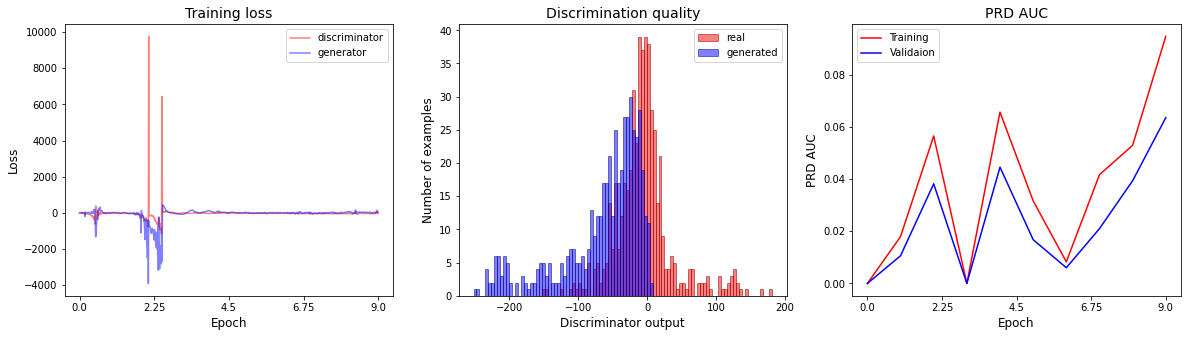

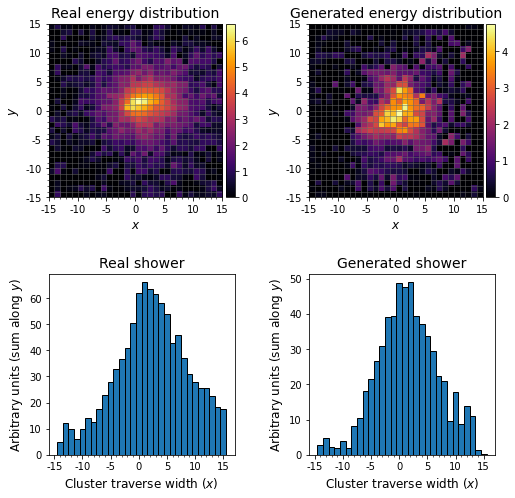



100%|██████████| 10/10 [1:19:41<00:00, 478.10s/it]


"\n\nwith open(def_colab_path + filename, 'wb') as pickle_file:\n    pickle.dump(tr_class, pickle_file)\n"

In [ ]:
import pickle

NOISE_DIM = 30
N_EPOCHS  = 10
#filename = 'wasserstein_withSN_26apr.pt'

# Max train  dataset size = 50250
# Training   dataset size = 47178
# Validation dataset size = 3072

tr_class, pos_gen_models = train_model(N_EPOCHS, -123., train_size = 47178, valid_size = 3072,
                                       batch_size=512,
                                       discriminator = ModelD(), 
                                       generator = PositiveEnergyReLUGenerator(z_dim=NOISE_DIM),
                                       dis_iter_num=2, gen_iter_num=1,
                                       loss='WASSERSTEIN',
                                       if_logarithm_energies=True)
'''

with open(def_colab_path + filename, 'wb') as pickle_file:
    pickle.dump(tr_class, pickle_file)
'''